# Using pre-trained NN

In [1]:
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from imageio import imread
import pickle

/home/hov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Model Zoo
* https://github.com/keras-team/keras/tree/master/keras/applications
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [ ]:
# download vgg16 weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5

#### Very Deep Convolutional Networks for Large-Scale Visual Recognition
VGG at Oxford: http://www.robots.ox.ac.uk/~vgg/research/very_deep/
<br>
### [layer configuration](https://gist.githubusercontent.com/ksimonyan/211839e770f7b538e2d8/raw/0067c9b32f60362c74f4c445a080beed06b07eb3/VGG_ILSVRC_16_layers_deploy.prototxt)
Build a model based on **layer configuration** below

In [2]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten # You may need this :)

In [3]:
img_input = Input(shape=(224, 224, 3), name="input")


conv1_1 = Conv2D(64, 3, padding="same", name="conv1_1", activation="relu")(img_input)
conv1_2 = Conv2D(64, 3, padding="same", name="conv1_2", activation="relu")(conv1_1)
pool1   = MaxPool2D(strides=2, padding="same", name="pool1")(conv1_2)

conv2_1 = Conv2D(128, 3, padding="same", name="conv2_1", activation="relu")(pool1)
conv2_2 = Conv2D(128, 3, padding="same", name="conv2_2", activation="relu")(conv2_1)
pool2   = MaxPool2D(strides=2, padding="same", name="pool2")(conv2_2)

conv3_1 = Conv2D(256, 3, padding="same", name="conv3_1", activation="relu")(pool2)
conv3_2 = Conv2D(256, 3, padding="same", name="conv3_2", activation="relu")(conv3_1)
conv3_3 = Conv2D(256, 3, padding="same", name="conv3_3", activation="relu")(conv3_2)
pool3   = MaxPool2D(strides=2, padding="same", name="pool3")(conv3_3)

conv4_1 = Conv2D(512, 3, padding="same", name="conv4_1", activation="relu")(pool3)
conv4_2 = Conv2D(512, 3, padding="same", name="conv4_2", activation="relu")(conv4_1)
conv4_3 = Conv2D(512, 3, padding="same", name="conv4_3", activation="relu")(conv4_2)
pool4   = MaxPool2D(strides=2, padding="same", name="pool4")(conv4_3)

conv5_1 = Conv2D(512, 3, padding="same", name="conv5_1", activation="relu")(pool4)
conv5_2 = Conv2D(512, 3, padding="same", name="conv5_2", activation="relu")(conv5_1)
conv5_3 = Conv2D(512, 3, padding="same", name="conv5_3", activation="relu")(conv5_2)
pool5   = MaxPool2D(strides=2, padding="same", name="pool5")(conv5_3)

flatten = Flatten()(pool5)

fc6     = Dense(4096, activation="relu", name="fc6")(flatten)
drop1   = Dropout(0.5)(fc6)

fc7     = Dense(4096, activation="relu", name="fc7")(drop1)
drop2   = Dropout(0.5)(fc7)

fc8     = Dense(1000, activation="relu", name="fc8")(drop2)

output  = Activation("softmax", name="prob")(fc8)

model = keras.Model(img_input, output)

You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 224, 224, 3). Without this transformation, vgg16 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [4]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:,:,::-1].astype(np.float64)
    for i in range(3):
        img[:,:,i] -= MEAN_VALUES[i]
        
    # convert from [w,h,3 to 1,w,h,3]
    return img[None]

def deprocess(img):
    img = img.reshape(img.shape[1:])
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [5]:
# load vgg16 weights
import h5py
with h5py.File("vgg16_weights_tf_dim_ordering_tf_kernels.h5", "r") as f:
    vgg16_weights = {k1: {k2:v2.value for k2, v2 in v1.items()} 
                     for k1, v1 in f.items() if len(v1)>0}

Now we should put the weights into their places:

In [6]:
weightKeys = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 
              'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 
              'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2',
              'block5_conv3', 'fc1',  'fc2', 'predictions']

In [7]:
weights = [[vgg16_weights[x][x+"_W_1:0"], vgg16_weights[x][x+"_b_1:0"]] for x in weightKeys]

In [8]:
[list(w)[0].shape for w in weights]

[(3, 3, 3, 64),
 (3, 3, 64, 64),
 (3, 3, 64, 128),
 (3, 3, 128, 128),
 (3, 3, 128, 256),
 (3, 3, 256, 256),
 (3, 3, 256, 256),
 (3, 3, 256, 512),
 (3, 3, 512, 512),
 (3, 3, 512, 512),
 (3, 3, 512, 512),
 (3, 3, 512, 512),
 (3, 3, 512, 512),
 (25088, 4096),
 (4096, 4096),
 (4096, 1000)]

In [9]:
layers = [1,2,4,5,7,8,9,11,12,13,15,16,17,20,22,24]

In [10]:
(len(layers),len(weights))

(16, 16)

In [11]:
for i,w in zip(layers, weights):
    model.layers[i].set_weights(w)

In [12]:
# classes' names are stored here
with open("classes.txt", "r") as f:
    classes = f.read().splitlines()
# for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


### Sanity check
Lets check that out pretrained network is working. We have sample image of a "albatross" and lets check that out network predicts it well.

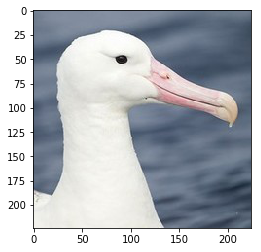

top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [13]:
img = imread('albatross.jpg')
plt.imshow(img)
plt.show()

p = model.predict(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

In [46]:
preprocess(imresize(cat,(IMAGE_W,IMAGE_W))).min()

/home/hov/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


-122.9780943627451

In [53]:
imresize(cat,(IMAGE_W,IMAGE_W), preserve_range=True)

/home/hov/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[[ 39.125     ,  44.125     ,  40.125     ],
        [ 39.5703125 ,  44.06138393,  41.58816964],
        [ 40.84821429,  44.84821429,  45.54464286],
        ...,
        [209.15066964, 207.52901786, 178.9140625 ],
        [204.10602679, 201.10602679, 167.25111607],
        [200.69084821, 198.52120536, 161.03013393]],

       [[ 40.        ,  45.        ,  41.        ],
        [ 40.        ,  44.49107143,  42.01785714],
        [ 40.53013393,  44.53013393,  45.2265625 ],
        ...,
        [204.25669643, 200.40848214, 172.80133929],
        [200.08816964, 197.08816964, 164.4921875 ],
        [197.58705357, 195.10602679, 158.67633929]],

       [[ 39.26897321,  44.26897321,  40.26897321],
        [ 38.75      ,  43.24107143,  40.76785714],
        [ 38.21986607,  42.21986607,  42.91629464],
        ...,
        [197.42075893, 193.3828125 , 167.02566964],
        [199.11160714, 194.86160714, 163.82254464],
        [201.95089286, 197.70089286, 164.703125  ]],

       ...,

      

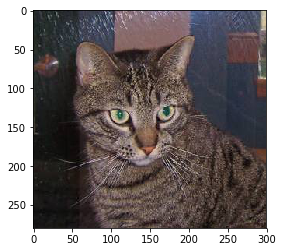

/home/hov/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


top-5 classes are:
0.462707	tabby
0.354755	tiger cat
0.100285	Egyptian cat
0.005147	radiator
0.004757	space heater


In [55]:
from skimage.transform import resize as imresize
cat = imread('cat.1.jpg')
plt.imshow(cat)
plt.show()

p = model.predict(preprocess(imresize(cat,(IMAGE_W,IMAGE_W), preserve_range=True)))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%)

In [59]:
genFeatures = keras.Model(img_input, fc6)

In [61]:
#extract features from images
from tqdm import tqdm
from skimage.transform import resize as imresize
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')[:10]):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
#     print(img.shape)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W), preserve_range=True))
    features = genFeatures.predict(img)
    Y.append(y)
    X.append(features)

  0%|          | 0/10 [00:00<?, ?it/s]/home/hov/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


In [62]:
X = np.concatenate(X)
Y = Y[:len(X)]

In [63]:
pickle.dump(X, open("X.pkl",'wb'))
pickle.dump(Y, open("Y.pkl",'wb'))

In [64]:
X = np.asarray(pickle.load(open("X.pkl",'rb')))
Y = np.asarray(pickle.load(open("Y.pkl",'rb')))

In [65]:
X.max(axis=0),X.min(axis=0),X.mean(axis=0)

(array([16.324814 , 20.30572  ,  2.0313945, ...,  0.       , 12.179208 ,
         0.       ], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([1.6324813, 2.317572 , 0.3548695, ..., 0.       , 2.2177246,
        0.       ], dtype=float32))

In [66]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, Y_val = train_test_split(X_train,y_train, test_size=0.25)

In [67]:
import gc
gc.collect()

4826

In [68]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import keras.optimizers as opts
from keras import losses

In [69]:
(X_train.shape,X_val.shape,X_test.shape)

((6, 4096), (2, 4096), (2, 4096))

In [70]:
inpt = Input(shape=(4096,), name="in")

l1     = Dense(2000, activation="relu", name="l1",)(inpt)

l2     = Dense(100, activation="relu", name="l2")(l1)
# drop1   = Dropout(0.5)

output = Dense(1, activation="sigmoid", name="out")(l2)
# drop1   = Dropout(0.5)

mymodel = keras.Model(inpt, output)

In [71]:
opt = opts.Adam(lr=1e-10)
mymodel.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['accuracy'])
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 4096)              0         
_________________________________________________________________
l1 (Dense)                   (None, 2000)              8194000   
_________________________________________________________________
l2 (Dense)                   (None, 100)               200100    
_________________________________________________________________
out (Dense)                  (None, 1)                 101       
Total params: 8,394,201
Trainable params: 8,394,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = mymodel.fit(X_train, y_train, epochs=10 ,batch_size=200,
                      validation_data=(X_val, Y_val))

Train on 6 samples, validate on 2 samples
Epoch 1/10


In [25]:
probs = mymodel.predict(X_train)
(probs.min(), probs.mean(), probs.max())

(0.3334059, 0.46723163, 0.6637676)

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `mysupermegaoptimizer.minimize(loss, var_list=<only_those_weights_i_wanna_train>)`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * You can have two optimizers: one for old network and one for new network
      * `old_net_optimizer.minimize(loss, old_net_weigts)`
      * `new_net_optimizer.minimize(loss, new_net_weigts)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
      * get test data https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screenshot pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
print("I can do it!")